In [1]:
import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.nn import Module
from tqdm import tqdm
import numpy as np

from env.env_simple_move import HumanMoveSimpleAction

from pytz import timezone
from datetime import datetime

TZ = timezone('Europe/Moscow')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
DEVICE

device(type='cuda')

In [3]:
class MoveNet(Module):
    def __init__(self, n_state, n_action, n_hidden=256, lr=0.005):
        super(MoveNet, self).__init__()
        self.criterion = torch.nn.MSELoss()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_state, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_action)
            )
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr)

    def forward(self, state):
        return self.net(state)

    def update(self, state, action):
        state = torch.tensor(state, dtype=torch.float32, device=DEVICE)
        action = torch.tensor(action, dtype=torch.float32, device=DEVICE)
        action_by_net = self.net(state)
        loss = self.criterion(action_by_net, action)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        action = self.forward(state)
        action = action.detach().cpu().numpy()[0]
        #action = np.clip(action, -1.0, 1.0)
        return action
    
        


In [13]:
env = HumanMoveSimpleAction(render_mode = 'human')
n_state = env.observation_space.shape[0]
n_action = env.action_space.shape[0]
n_hidden = 256
lr = 0.005
model = MoveNet(n_state, n_action, n_hidden, lr).to(DEVICE)
loss_f = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.net.parameters(), lr)

In [28]:
n_episode = 1
total_reward_episode = np.zeros(n_episode)

for n in tqdm(range(n_episode)):

    state, _ = env.reset(seed=42)
    
    is_done = False
    is_break = False
    sum_reward = 0

    while not is_done and not is_break:
        action = model.get_action(state)
        teach_action = env.teach_action(state)
        print(action)
        print(teach_action)
        next_state, reward, is_done, is_break, _ = env.step(action)
        sum_reward += reward

        model.update(state, teach_action)
        state = next_state

    total_reward_episode[n] = sum_reward

  0%|          | 0/1 [00:00<?, ?it/s]

[ 9.2570925e-01  1.3264854e-01  1.3247570e-01  9.0943474e-01
  1.7729546e-03 -6.4973673e-04]
[1.         0.93012713 0.93012713 1.         0.         0.        ]
[ 9.2603278e-01  1.2951671e-01  1.2932391e-01  9.0980285e-01
  1.7611764e-03 -6.4760412e-04]
[1.         0.93364646 0.93364646 1.         0.         0.        ]
[ 9.2635518e-01  1.2704007e-01  1.2683162e-01  9.1016978e-01
  1.7494670e-03 -6.4547686e-04]
[1.         0.93712229 0.93712229 1.         0.         0.        ]
[ 9.2667639e-01  1.2515604e-01  1.2493581e-01  9.1053551e-01
  1.7378262e-03 -6.4335496e-04]
[1.         0.94045326 0.94045326 1.         0.         0.        ]
[ 9.2699647e-01  1.2380794e-01  1.2357944e-01  9.1090000e-01
  1.7262535e-03 -6.4123835e-04]
[1.         0.94365343 0.94365343 1.         0.         0.        ]
[ 9.2731541e-01  1.2294443e-01  1.2271085e-01  9.1126329e-01
  1.7147487e-03 -6.3912710e-04]
[1.         0.94679671 0.94679671 1.         0.         0.        ]
[ 9.2763317e-01  1.2251907e-01  1.

100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

[ 9.3888831e-01  1.4235127e-01  1.4225946e-01  9.2452186e-01
  1.3155607e-03 -5.6086789e-04]
[ 1.         -0.96963664 -0.96963664  1.          0.          0.        ]
[ 9.3916368e-01  1.3866730e-01  1.3855289e-01  9.2483926e-01
  1.3065098e-03 -5.5896380e-04]
[ 1.         -0.96842221 -0.96842221  1.          0.          0.        ]


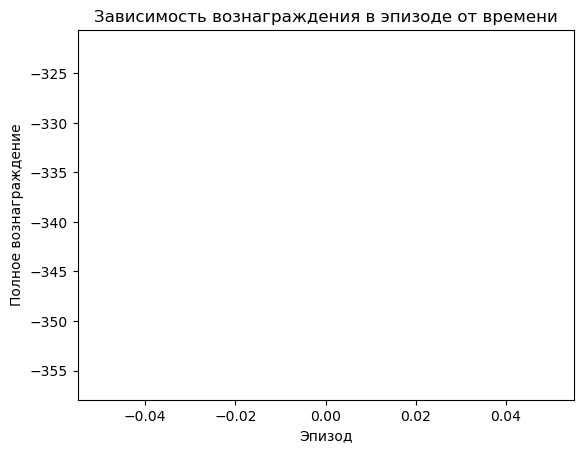

In [23]:
import matplotlib.pyplot as plt

plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

In [10]:
seed = 42#int( datetime.now(TZ).strftime("%H%M%S") )
env_render = HumanMoveSimpleAction(seed=seed, render_mode = 'human')
total_reward = 0.
step_reward = []
observation, _ = env_render.reset()
terminated = False
truncated = False
while not terminated and not truncated:
    action = model.get_action(observation)
    print(action)
    observation, reward, terminated, truncated, _ = env_render.step(action)
    total_reward += reward
    step_reward.append(reward)

total_reward

[ 9.9999976e-01  1.3736109e-01  1.3733420e-01  9.9999934e-01
  1.1210388e-44 -2.8025969e-45]
[ 9.9999976e-01  1.3736109e-01  1.3733420e-01  9.9999934e-01
  1.1210388e-44 -2.8025969e-45]
[ 9.9999976e-01  1.3736109e-01  1.3733420e-01  9.9999934e-01
  1.1210388e-44 -2.8025969e-45]
[ 9.9999976e-01  1.3736109e-01  1.3733420e-01  9.9999934e-01
  1.1210388e-44 -2.8025969e-45]
[ 9.9999976e-01  1.3736109e-01  1.3733420e-01  9.9999934e-01
  1.1210388e-44 -2.8025969e-45]
[ 9.9999976e-01  1.3736109e-01  1.3733420e-01  9.9999934e-01
  1.1210388e-44 -2.8025969e-45]
[ 9.9999976e-01  1.3736109e-01  1.3733420e-01  9.9999934e-01
  1.1210388e-44 -2.8025969e-45]
[ 9.9999976e-01  1.3736109e-01  1.3733420e-01  9.9999934e-01
  1.1210388e-44 -2.8025969e-45]
[ 9.9999976e-01  1.3736109e-01  1.3733420e-01  9.9999934e-01
  1.1210388e-44 -2.8025969e-45]
[ 9.9999976e-01  1.3736109e-01  1.3733420e-01  9.9999934e-01
  1.1210388e-44 -2.8025969e-45]
[ 9.9999976e-01  1.3736109e-01  1.3733420e-01  9.9999934e-01
  1.12103

-314.31023312013394

In [29]:
env_render.close()